In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

from compute import *
from defPlot import *

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error', protocol = 'tcp://',
                      host = '137.129.155.67')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36871 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:36871/status,
Dashboard: http://137.129.155.67:36871/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: tcp://137.129.155.67:34005,Workers: 1
Dashboard: http://137.129.155.67:36871/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: tcp://137.129.155.67:39737,Total threads: 4
Dashboard: http://137.129.155.67:40239/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
indir_data_RAW = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/'
indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/TCWV/'
indir_data_VAR = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/VARIANCE/ANOMALY_FILTERED/'
indir_data_VAR_TOT = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/ANALYSIS/VARIANCE/RAW_ANOMALY/'

var_file = '*'


In [3]:
### Parameter for the analysis
year = 2009
latitude = 10.5
longitude = 0.5

wave = ['TCWV_Kelvin','TCWV_Rossby','TCWV_MJO','TCWV_MRG','TCWV_TD']
coeff = 2

day1 = '2009-07-01'
day2 = '2009-10-01'

### Open DATA
ds_RAW = xr.open_mfdataset(indir_data_RAW+'*'+var_file+'*'+str(year)+'.nc', chunks = {'time' : 1}, parallel=True)
ds_RAW = ds_RAW.rename({'latitude':'lat', 'longitude':'lon'})

ds_FILTER = xr.open_mfdataset(indir_data_FILTERED + '*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True)

ds_VAR = xr.open_mfdataset(indir_data_VAR + 'TCWV_JAS.nc', chunks = {'time' : 1}, parallel=True)
ds_VAR_TOT = xr.open_mfdataset(indir_data_VAR_TOT + 'TCWV_YEAR.nc', chunks = {'time' : 1}, parallel=True)
ds_VAR_TOT = ds_VAR_TOT.rename({'latitude':'lat', 'longitude':'lon'})

ds_RAW = ds_RAW.isel(lat = slice(2,None,4), lon = slice(2,None,4))
ds_FILTER = ds_FILTER.isel(lat = slice(2,None,4), lon = slice(2,None,4))
ds_VAR = ds_VAR.isel(lat = slice(2,None,4), lon = slice(2,None,4))
ds_VAR_TOT = ds_VAR_TOT.isel(lat = slice(2,None,4), lon = slice(2,None,4))

ds_RAW = ds_RAW.sel(lat = slice(30, -30))
ds_FILTER = ds_FILTER.sel(lat = slice(30, -30))
ds_VAR = ds_VAR.sel(lat = slice(30, -30))
ds_VAR_TOT = ds_VAR_TOT.sel(lat = slice(30, -30))

ds_RAW = ds_RAW.reindex(lat=list(reversed(ds_RAW.lat)))
ds_FILTER = ds_FILTER.reindex(lat=list(reversed(ds_FILTER.lat)))
ds_VAR = ds_VAR.reindex(lat=list(reversed(ds_VAR.lat)))
ds_VAR_TOT = ds_VAR_TOT.reindex(lat=list(reversed(ds_VAR_TOT.lat)))

ds_FILTER = ds_FILTER.assign_coords(lon = (((ds_FILTER.lon + 180) % 360) - 180)).sortby('lon')
ds_VAR = ds_VAR.assign_coords(lon = (((ds_VAR.lon + 180) % 360) - 180)).sortby('lon')
ds_RAW = ds_RAW.assign_coords(lon = (((ds_RAW.lon + 180) % 360) - 180)).sortby('lon')


In [4]:
### Compute standard deviation
for w in wave :
    ds_VAR_mean = ds_VAR.mean().compute()
    ds_std_mean = ds_VAR_mean**(0.5)
    ds_std = ds_VAR**(0.5)
    da_std_TOT = ds_VAR_TOT['tcwv_ano']**(0.5)
    ds_FILTER = addNegative(ds_FILTER, ds_std_mean, ds_std, w, da_std_TOT)

# Vision en 1D en différents points du globe
On selectionne des données en plein ocean et sur le continent dans la bande équatoriale

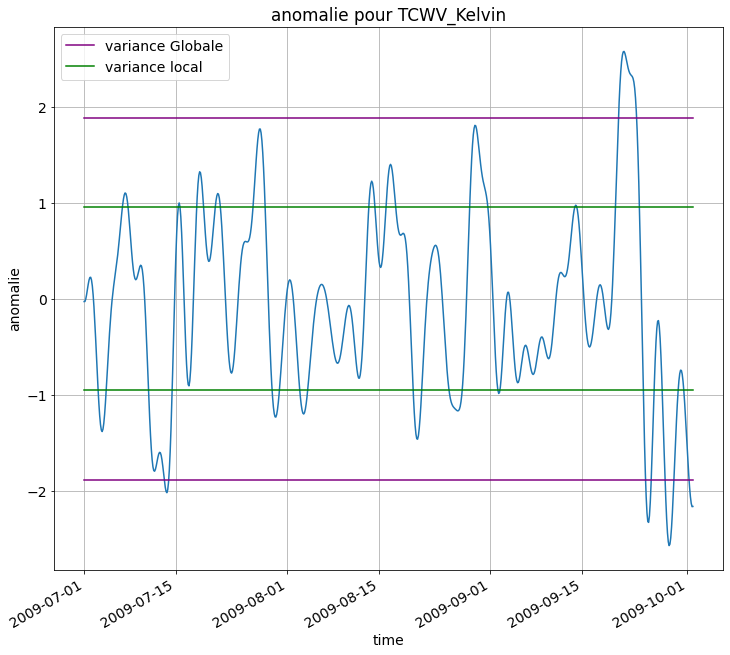

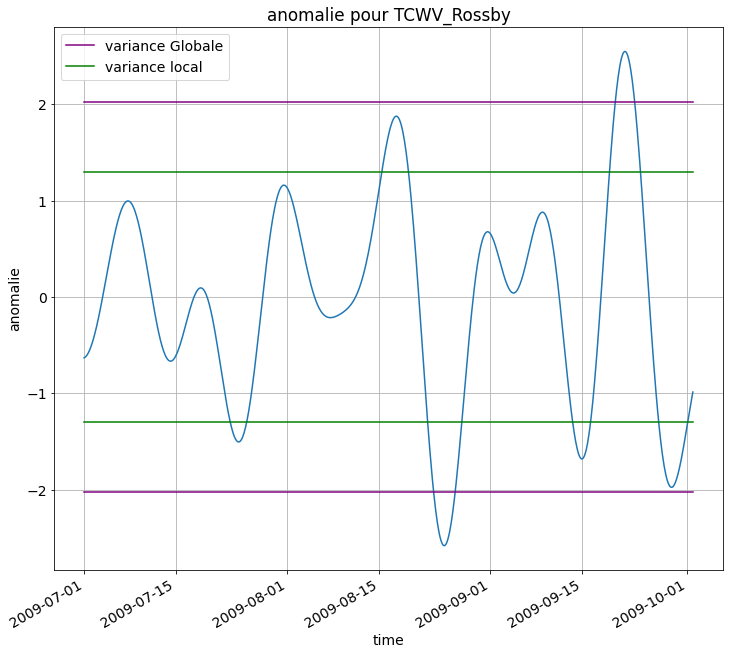

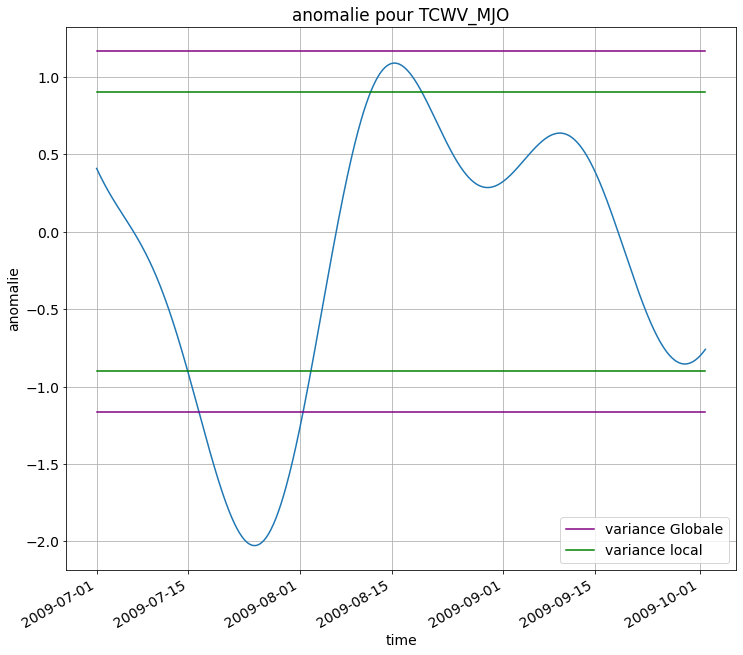

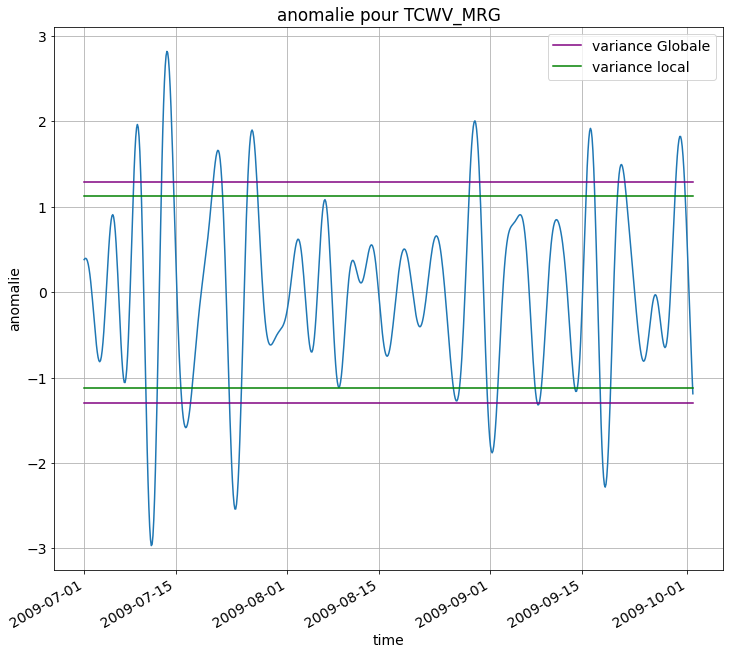

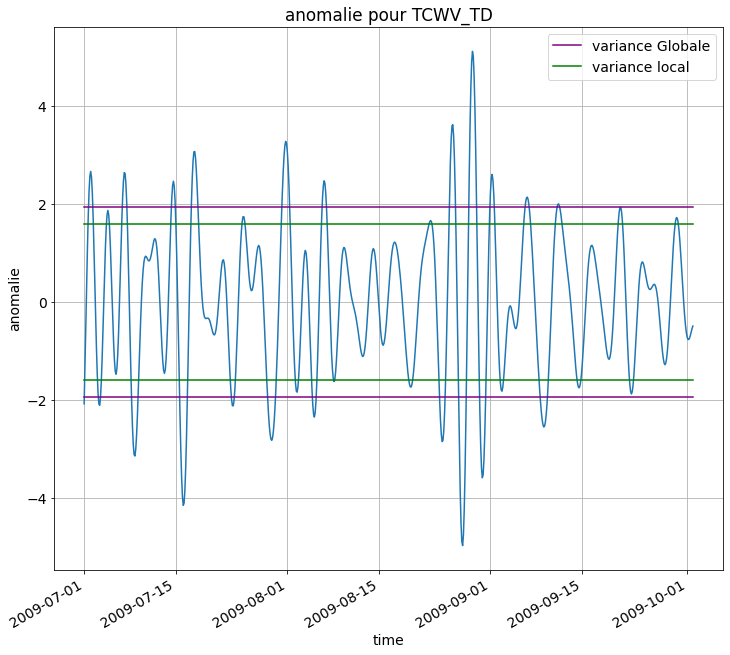

In [5]:
_ds_FILTER = ds_FILTER.sel(time = slice(day1,day2), lat = slice(0,15), lon = slice(-5,5))
_ds_std = ds_std.sel(lat = slice(0,15), lon = slice(-5,5))
for w in wave :
    plotline1D(_ds_FILTER, latitude, longitude, w)


# Plot 2D
On calcule le nombre de jours qui se situe au dessus de l'écart-type, de 2 écart-type, et de 3 ecart-type.
On doit séparer le nombre de jour dans le négatif et dans le positif, le négatif étant un indice de convection. 

In [6]:
_ds_FILTER = ds_FILTER.sel(time = slice(day1,day2), lat = slice(0,15), lon = slice(-5,5))
_ds_std = ds_std.sel(lat = slice(0,15), lon = slice(-5,5))

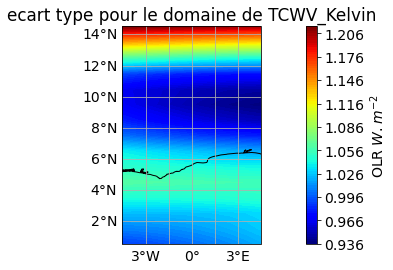

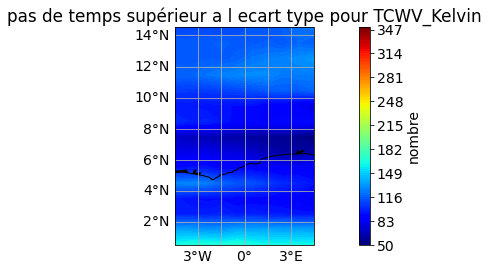

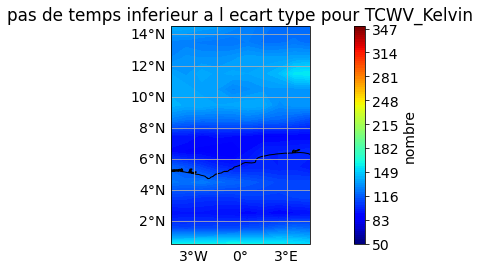

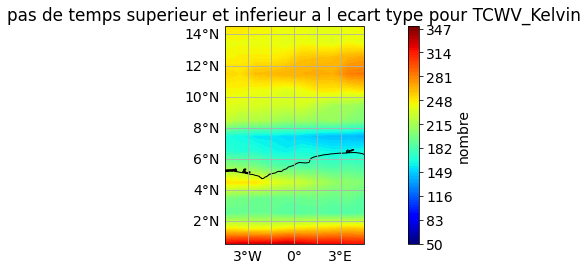

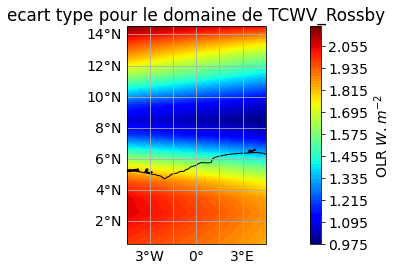

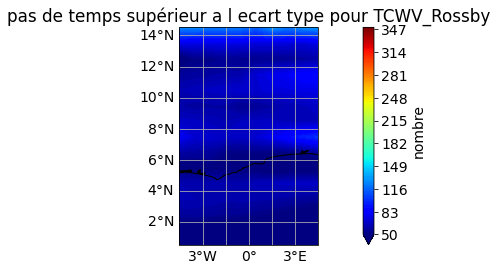

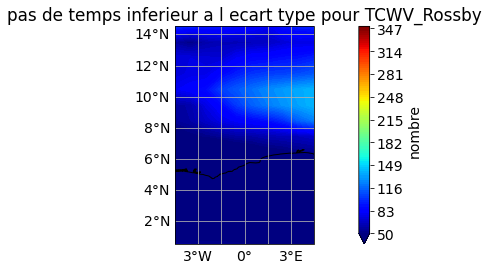

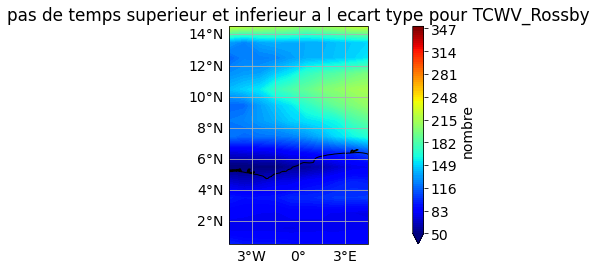

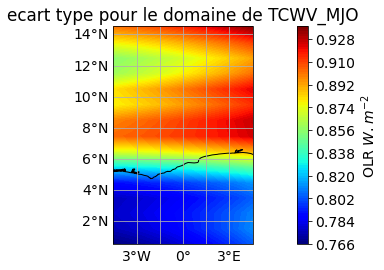

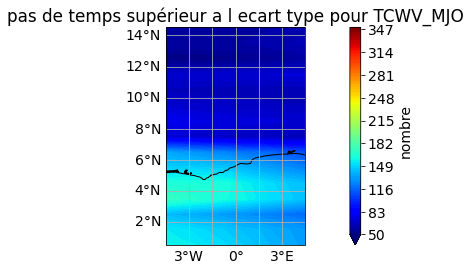

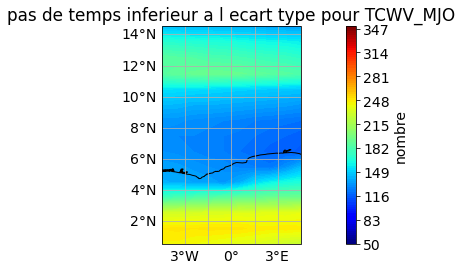

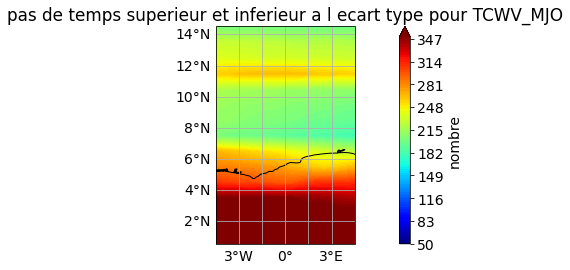

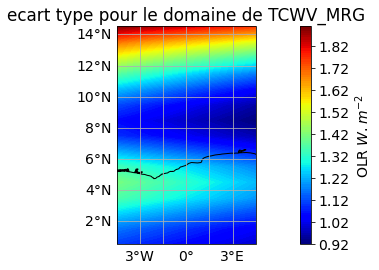

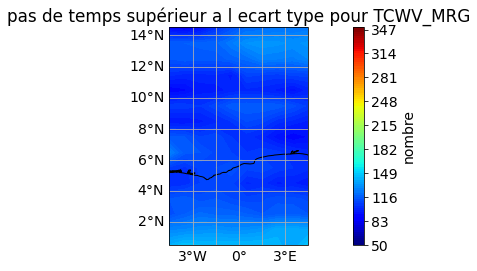

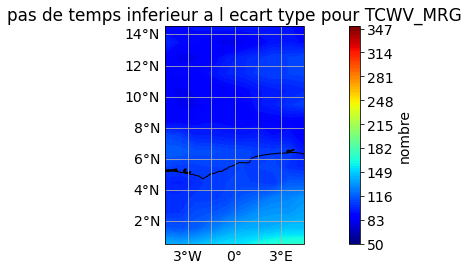

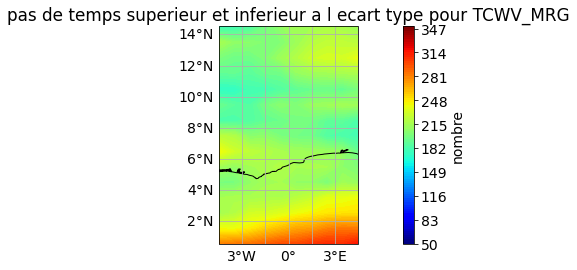

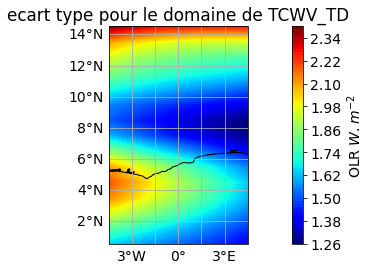

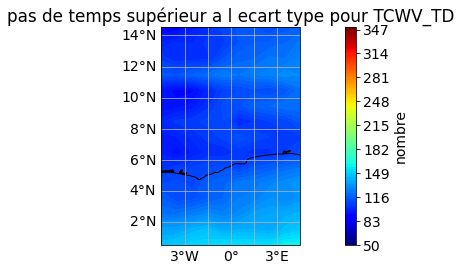

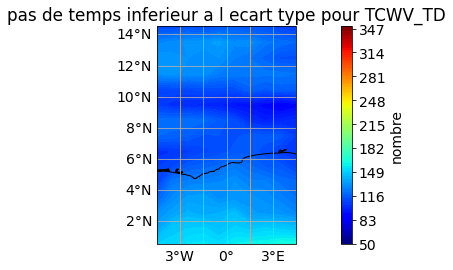

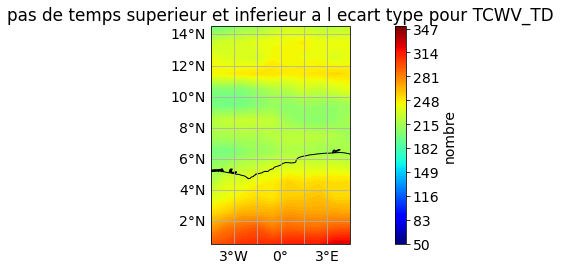

In [7]:
for w in wave:
    _da_nb_jour, _da_nb_jour_N = computeDayBelowAbove(_ds_FILTER,_ds_std,coeff, w)
    plot2DnbDay(_ds_std, _da_nb_jour, _da_nb_jour_N, w)
# plot2DnbDayP(ds_FILTER, ds_std, _da_nb_jour, _da_nb_jour_N, wave = wave)